## Squeeze and excitation block(https://arxiv.org/abs/1709.01507) in ResNet architecture.
### В этой тетрадке мы снова будем эксперементировать с ResNet-ом и разнообразными блоками. Но для начала давайте поговорим о конволюциях.
### У операции конволюции есть один недостаток: даже на последних слоях, receptive field каждого пикселя в карте будет меньше размером, чем исходное изображения, а значит при получении этого пикселя была учтена не вся пространственная и канальная информация.
### Блок Squeeze and excitation использует информацию о всем исходном изображении на всех этапах обучения. Это происходит благодоря двум частям, которые дополняют обычный ResNet блок.
<img src='pictures/se_block.png'>
____________
## __Squeeze block__ 
#### В этом блоке происходит объединение карт признаков по средствам gloabl average pooling'a, то есть считается среднее по каждой карте и на выходе получается вектор из признаков с описанием карт. Этот вектор содержит глобальную информацию о картах, позволяя получать информацию сразу же о всем изображении.
<img src='pictures/squeeze.png'>
## __Excitation block__
#### Если squeeze блок выявлял пространственные корреляции, то данный блок отвечает за объединение информации из разных каналов . Это делается по стредствам полносвязных слоев с активациями.
#### Для того, чтобы не сильно увеличиавать количество параметров, формируется bottleneck, который уменьшает количество весов.
<img src='pictures/exictation.png'>
### После прохождения блоков, описанных выше, мы получаем вероятности (Так как последняя активация-сигмойда), которые можно интерпретировать по разному, мы же будем говорить о том, что они выражают важность данной карты. То есть, чем меньше вероятность, тем меньше будут значения в данной карте, а значит, они скорее всего будут меньше влиять на выход сети.

In [1]:
import os
import sys

import blosc
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import ewma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from IPython.display import clear_output
%matplotlib inline

sys.path.append('..')
from se_resnet import SEResNet
from dataset import Dataset, DatasetIndex

### Load data

In [2]:
src = './../MNIST_data'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    images = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    labels = blosc.unpack_array(file.read())

### Create dataset

In [3]:
ix = DatasetIndex(range(65000))
dset = Dataset(ix, SEResNet)
dset.cv_split()

### train models 

In [4]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

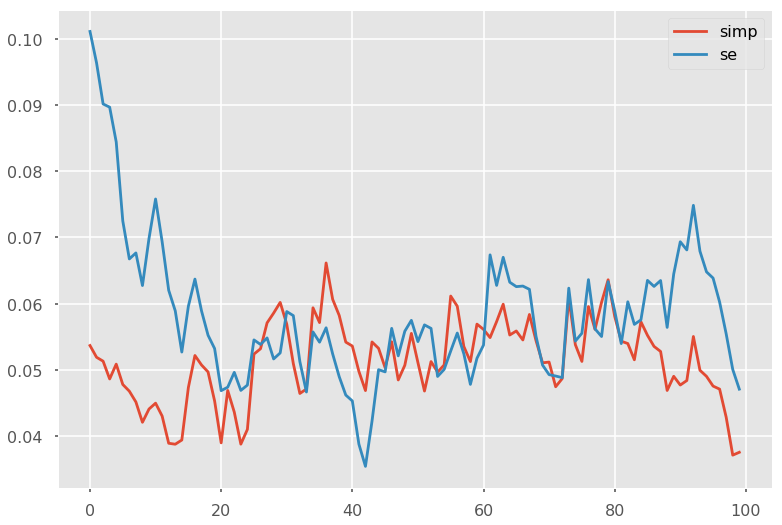

In [5]:

se_loss, bottle_loss = [], []
se_acc, bottle_acc = [], []
bottle_time, se_time = np.zeros(1), np.zeros(1)

train_pipeline = (dset.train.
                 p.
                 train_bottle([images, labels], bottle_loss, bottle_time).
                 train_se([images, labels], se_loss, se_time))
test_pipeline = (dset.test.p
                .import_model("bottlenet", train_pipeline)
                .import_model("seResNet", train_pipeline) 
                .accuracy_se([images, labels], se_acc)
                .accuracy_bottle([images, labels], bottle_acc))

for i in tqn(range(500)):
    train_pipeline.next_batch(300, n_epochs=None, shuffle=2)
    test_pipeline.next_batch(300, n_epochs=None, shuffle=2)
    if i%10==0:
        clear_output(True)
        plt.plot(ewma(np.array(bottle_loss[-100:]),span=10,adjust=False), label='simp')
        plt.plot(ewma(np.array(se_loss[-100:]),span=10,adjust=False), label='se')
        plt.legend()
        plt.show()

In [6]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')
from IPython.display import clear_output
from pandas import ewma
def draw(bottle_loss, stochastic_loss, y, bound=[0, 500, 0, 1]):
    """ Draw graphs to compare models. The graph shows a comparison of the average 
        values calculated with a window in 10 values.
    Args:
        freeze_loss: List with loss value in resnet and freezeout model
        res_loss: List with loss value in clear resnet
        src: List with parameters of model with FreezeOut
        ax: Plt sublot """
    bl_loss = ewma(np.array(bottle_loss),span=50,adjust=False)
    st_loss = ewma(np.array(stochastic_loss),span=50,adjust=False)
    
    plt.plot(bl_loss, label='Bottle {}'.format(y))
    plt.plot(st_loss, label='Squeeze and excitation {}'.format(y))
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel(y, fontsize=16)
    plt.legend(fontsize=14)
    plt.axis(bound)


### Выведем график loss функции в процессе обучения

/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]
/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


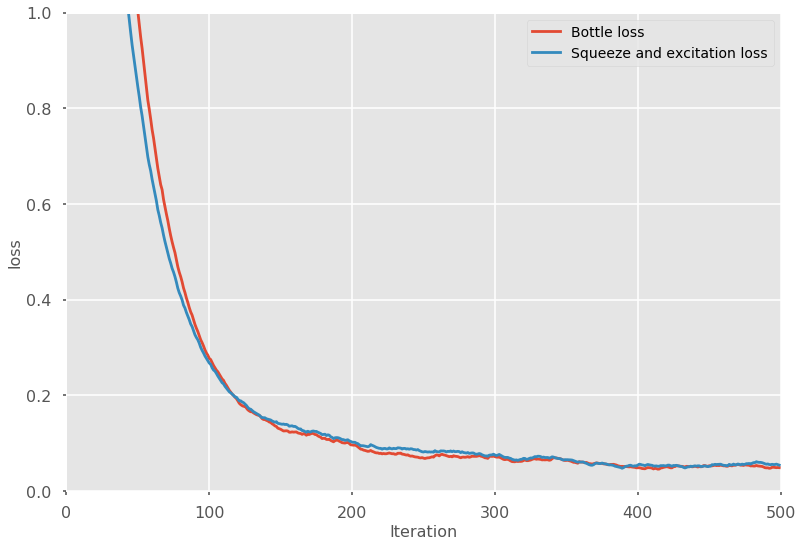

In [7]:
draw(bottle_loss, se_loss , 'loss')

### Для более точного анализа, выведем последние 200 итераций.

/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  del sys.path[0]
/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


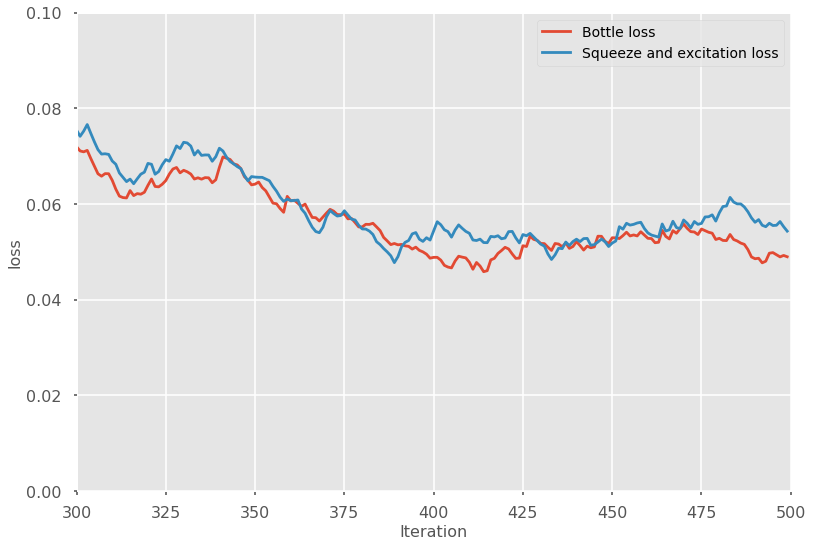

In [8]:
draw(bottle_loss, se_loss, 'loss', [300, 500, 0, 0.1])

### По графикам видно, что SE блоки действительно дают прирост в качестве моделей и, в принципе не сильно влияют на скорость обучения. Благодоря bottleneck-у количество параметров в SE_ResNet'e(23994378 параметров) не сильно превышает обычный ResNet(23495690 параметров).

### SeResNet

In [9]:
col = sns.color_palette("Set2", 8) + sns.color_palette(["#9b59b6", "#3498db"])

def draw_avgpooling(maps, ppl, model=True):
    ppl.next_batch(500)
    answers = np.argmax(maps['answers'][0], axis=-1)
    indices = np.array([np.where(answers == i)[0] for i in range(10)])

    filters = np.array([np.mean(maps['avgpool'][0][indices[i]], axis=0).reshape(-1) for i in range(10)])
    for i in range(10):
        plt.plot(ewma(filters[i], span=350, adjust=False), color=col[i], label=str(i))

    plt.title("Distribution of average pooling in " + ("SE ResNet" if model else 'simple ResNet'))
    plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Activation', fontsize=18)
    plt.xlabel('Filter index', fontsize=18)
    plt.axis([0, 2060, 0, 1.])
    plt.show()

In [10]:
maps_se = {'avgpool':[], 'answers':[]}
maps_bo = {'avgpool':[], 'answers':[]}

get_se_ppl = (dset.test
                .p
                .import_model('seResNet', train_pipeline)
                .get_maps_se([images, labels],  maps_se))

get_bo_ppl = (dset.test
                .p
                .import_model('bottlenet', train_pipeline)
                .get_maps_bo([images, labels],  maps_bo))

/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


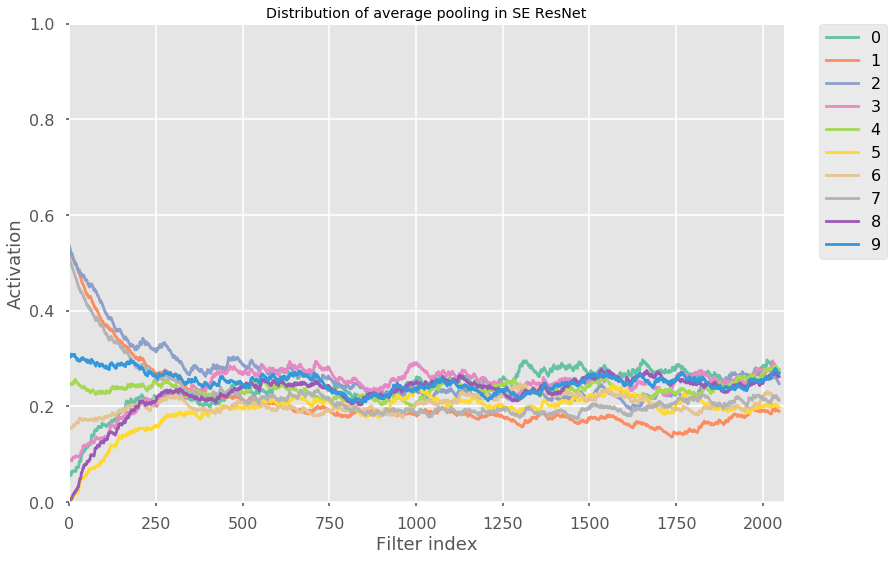

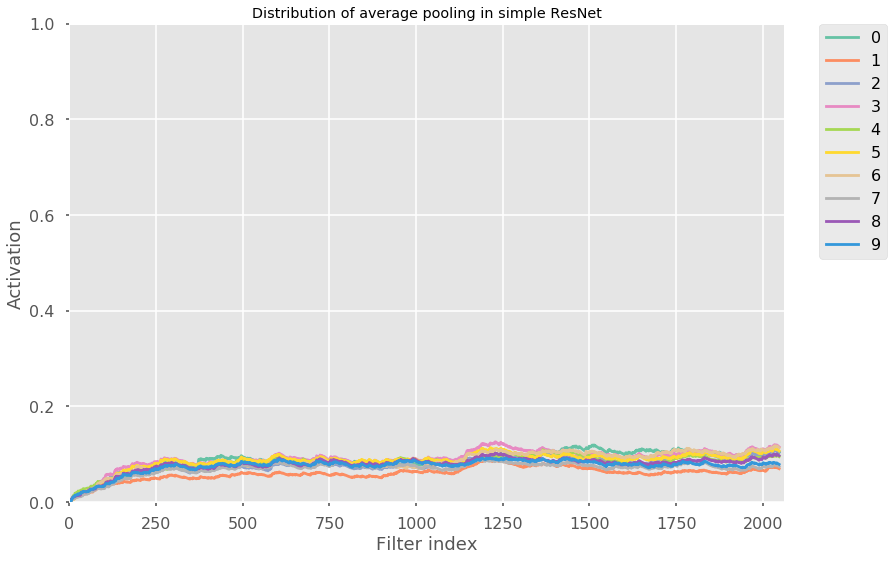

In [11]:
draw_avgpooling(maps_se, get_se_ppl)
draw_avgpooling(maps_bo, get_bo_ppl, False)

###  На графиках выше показаны распределения карт(фильтров) после Global Average Pooling-a в конце сети. По оси X - номер карты, по оси Y - усредненное значение в картах одного класса после GAP. Всего представленно 10 различных графиков, которые показывают распределения карт одного из классов. 
### Не трудно заметить, что распределение у SE ResNet'a обладает гораздо большей дисперсией. Что же это значит?
### Если активации фильтров различных классов расположенны далеко друг от друга, значит для незнакомой картинки, после прохождения всей сети будет легче предсказать класс, чем если бы распределения всех классов были слеплены в одну кучу.
### Расширение дисперсии происходит за счет наличия полносвязных слоев, которые, как говорилось выше, работают с канальными признаками. Аггрегируя информацию по каналам полносвязные слои выделяют разнообразные признаки, присущие различным классам, тем самым влияя на конечный ответ.